# Intro

Here we use NO perturbed cell-types.
This is done when we generate the pseudobulks by sampling from only non-perturbed cells within each sample.
This is denoted in the parameter `res_name`


This data QCs the Kang et.al. data to make sure everything looks good.
The data was retreived using  the SeuratData package in R and then translated into an AnnData object to be read into python,
Notebook for SeuratData analysis of Kang data (names ifnb in SeuratData): https://satijalab.org/seurat/articles/integration_introduction.html
Seurat Disk was used for conversion between h5Seurat and AnnData: https://mojaveazure.github.io/seurat-disk/articles/convert-anndata.html

Kang data is originally from here: 
Kang, Hyun Min, et al. "Multiplexed droplet single-cell RNA-sequencing using natural genetic variation." Nature biotechnology 36.1 (2018): 89-94.

This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

# Imports

In [1]:
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess


# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path


# Parameters

In [2]:
# parameters

aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_kang_data/"
cibersort_path = f"{os.getcwd()}/../../data/single_cell_data/cibersort_kang/"
data_path = f"{os.getcwd()}/../../data/single_cell_data/kang_rybakov/"


num_cells_vec = [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


#####################
### set the study ###
#####################

res_name = "none-kang"
in_name = "ifnb_processed"
processed_sc_file = f"{data_path}/{in_name}.h5ad"



# Load and Process data

### Read in data and metadata

In [3]:
# read in the data

adata = sc.read_h5ad(processed_sc_file)

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`



In [4]:
# format metadata

adata.obs['CellType'] = adata.obs['seurat_names_merged'].tolist()
adata.obs['scpred_CellType'] = adata.obs['seurat_names_merged'].tolist()
adata.obs['sample_id'] = [str(x) for x in adata.obs['sample_id'].tolist()]

adata.var['gene_ids'] = adata.var['gene_annot'].tolist()


In [5]:
np.where(adata.var['gene_ids'] == "GNLY")

(array([1703]),)

In [6]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,stim,seurat_annotations,seurat_names,seurat_names_merged,BARCODE,sample_id,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CellType,scpred_CellType
AAACATACATTTCC.1,IMMUNE_CTRL,3017.0,877,CTRL,0,CD14_Mono,CD14_Mono,AAACATACATTTCC.1CTRL,1016,877,877,3017.0,0.0,0.0,CD14_Mono,CD14_Mono
AAACATACCAGAAA.1,IMMUNE_CTRL,2481.0,713,CTRL,0,CD14_Mono,CD14_Mono,AAACATACCAGAAA.1CTRL,1256,713,713,2481.0,0.0,0.0,CD14_Mono,CD14_Mono
AAACATACCTCGCT.1,IMMUNE_CTRL,3420.0,850,CTRL,0,CD14_Mono,CD14_Mono,AAACATACCTCGCT.1CTRL,1256,850,850,3420.0,0.0,0.0,CD14_Mono,CD14_Mono
AAACATACCTGGTA.1,IMMUNE_CTRL,3156.0,1109,CTRL,11,pDC,DC,AAACATACCTGGTA.1CTRL,1039,1109,1109,3156.0,0.0,0.0,DC,DC
AAACATACGATGAA.1,IMMUNE_CTRL,1868.0,634,CTRL,2,CD4_Mem_T,CD4_Mem_T,AAACATACGATGAA.1CTRL,1488,634,634,1868.0,0.0,0.0,CD4_Mem_T,CD4_Mem_T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGAACGAA.1,IMMUNE_STIM,5577.0,1237,STIM,8,DC,DC,TTTGCATGAACGAA.1STIM,1244,1237,1237,5577.0,0.0,0.0,DC,DC
TTTGCATGACGTAC.1,IMMUNE_STIM,1364.0,536,STIM,2,CD4_Mem_T,CD4_Mem_T,TTTGCATGACGTAC.1STIM,1488,536,536,1364.0,0.0,0.0,CD4_Mem_T,CD4_Mem_T
TTTGCATGCCTGTC.1,IMMUNE_STIM,2114.0,817,STIM,4,B,B,TTTGCATGCCTGTC.1STIM,1256,817,817,2114.0,0.0,0.0,B,B
TTTGCATGCTAAGC.1,IMMUNE_STIM,1522.0,523,STIM,1,CD4_Naive_T,CD4_Naive_T,TTTGCATGCTAAGC.1STIM,107,523,523,1522.0,0.0,0.0,CD4_Naive_T,CD4_Naive_T


### Preprocess

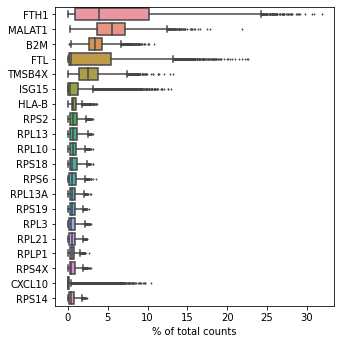

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [8]:
# check we don't have any weird cell types
adata.obs["scpred_CellType"].value_counts()


CD14_Mono      4361
CD4_Naive_T    2504
CD4_Mem_T      1762
B              1363
CD16_Mono      1044
CD8_T           813
T_Act           633
NK              619
DC              604
Mk              236
Name: scpred_CellType, dtype: int64

In [9]:
# write out data for BP and cibersort
dense_matrix = adata.X.todense()

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)

dense_df = pd.DataFrame(dense_matrix, columns = adata.var['gene_ids'])
dense_df.insert(loc=0, column='scpred_CellType', value=adata.obs["scpred_CellType"].to_list())


pickle.dump( dense_df, open( sc_profile_path, "wb" ) )


In [10]:
dense_matrix.shape

(13939, 13452)

# Plot Data

         Falling back to preprocessing with `sc.pp.pca` and default params.


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample_id' as categorical
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CellType' as categorical
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-p

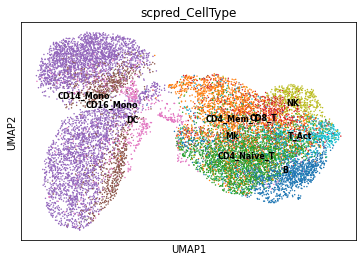

In [11]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)


# Make Pseudobulks

### First do some QC stats

In [12]:
adata.obs["sample_id"].value_counts()


1015    3177
1256    2396
1488    2280
1244    2031
1016    1484
101     1224
1039     679
107      668
Name: sample_id, dtype: int64

In [13]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,stim,seurat_annotations,seurat_names,seurat_names_merged,BARCODE,sample_id,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CellType,scpred_CellType
AAACATACATTTCC.1,IMMUNE_CTRL,3017.0,877,CTRL,0,CD14_Mono,CD14_Mono,AAACATACATTTCC.1CTRL,1016,877,877,3017.0,0.0,0.0,CD14_Mono,CD14_Mono
AAACATACCAGAAA.1,IMMUNE_CTRL,2481.0,713,CTRL,0,CD14_Mono,CD14_Mono,AAACATACCAGAAA.1CTRL,1256,713,713,2481.0,0.0,0.0,CD14_Mono,CD14_Mono
AAACATACCTCGCT.1,IMMUNE_CTRL,3420.0,850,CTRL,0,CD14_Mono,CD14_Mono,AAACATACCTCGCT.1CTRL,1256,850,850,3420.0,0.0,0.0,CD14_Mono,CD14_Mono
AAACATACCTGGTA.1,IMMUNE_CTRL,3156.0,1109,CTRL,11,pDC,DC,AAACATACCTGGTA.1CTRL,1039,1109,1109,3156.0,0.0,0.0,DC,DC
AAACATACGATGAA.1,IMMUNE_CTRL,1868.0,634,CTRL,2,CD4_Mem_T,CD4_Mem_T,AAACATACGATGAA.1CTRL,1488,634,634,1868.0,0.0,0.0,CD4_Mem_T,CD4_Mem_T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGAACGAA.1,IMMUNE_STIM,5577.0,1237,STIM,8,DC,DC,TTTGCATGAACGAA.1STIM,1244,1237,1237,5577.0,0.0,0.0,DC,DC
TTTGCATGACGTAC.1,IMMUNE_STIM,1364.0,536,STIM,2,CD4_Mem_T,CD4_Mem_T,TTTGCATGACGTAC.1STIM,1488,536,536,1364.0,0.0,0.0,CD4_Mem_T,CD4_Mem_T
TTTGCATGCCTGTC.1,IMMUNE_STIM,2114.0,817,STIM,4,B,B,TTTGCATGCCTGTC.1STIM,1256,817,817,2114.0,0.0,0.0,B,B
TTTGCATGCTAAGC.1,IMMUNE_STIM,1522.0,523,STIM,1,CD4_Naive_T,CD4_Naive_T,TTTGCATGCTAAGC.1STIM,107,523,523,1522.0,0.0,0.0,CD4_Naive_T,CD4_Naive_T


In [14]:
adata.obs["scpred_CellType"].unique()

['CD14_Mono', 'DC', 'CD4_Mem_T', 'T_Act', 'CD4_Naive_T', 'CD8_T', 'Mk', 'B', 'CD16_Mono', 'NK']
Categories (10, object): ['B', 'CD4_Mem_T', 'CD4_Naive_T', 'CD8_T', ..., 'DC', 'Mk', 'NK', 'T_Act']

### now split test and train cells


In [15]:
# generate cell-type specific split
adata.obs["isTraining"] = "Train"
adata.obs["test_train_key"] = adata.obs["scpred_CellType"].astype(str) + adata.obs["stim"].astype(str) + adata.obs["sample_id"].astype(str)

# for each element in the key
# split by 50%
for curr_key in adata.obs["test_train_key"].unique():
  curr_idx = np.where(adata.obs["test_train_key"] == curr_key)[0]
  num_sample = np.floor(len(curr_idx)/2).astype(int)
  test_idx = np.random.choice(curr_idx, num_sample)
  adata.obs["isTraining"][test_idx] = "Test"

/tmp/ipykernel_7921/3383829285.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["isTraining"][test_idx] = "Test"


In [16]:
pd.set_option('display.max_rows', 160)

tab = adata.obs.groupby(['test_train_key', 'isTraining']).size()

tab.unstack()

isTraining,Test,Train
test_train_key,,
BCTRL101,20,23
BCTRL1015,71,117
BCTRL1016,20,33
BCTRL1039,7,12
BCTRL107,8,17
BCTRL1244,22,47
BCTRL1256,43,66
BCTRL1488,34,51
BSTIM101,32,50


In [17]:
tab = adata.obs.groupby(['isTraining', 'sample_id']).size()

tab.unstack()

sample_id,101,107,1015,1016,1039,1244,1256,1488
isTraining,,,,,,,,
Test,487,270,1259,578,266,792,943,877
Train,737,398,1918,906,413,1239,1453,1403


In [18]:
tab = adata.obs.groupby(['isTraining', 'stim']).size()

tab.unstack()

stim,CTRL,STIM
isTraining,,
Test,2552,2920
Train,3971,4496


### Generate proportions matrix + pseudobulk

In [19]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )

# metadata
sample_order = ['1015', '1256', '1488', '1244', '1016', '101', '1039', '107']
stim_order = ['STIM', 'CTRL']
train_order = ['Train', 'Test']

# now generate all the proportions
total_meta_df = pd.DataFrame(columns = ["sample_id", "stim", "isTraining"])

# no cell noise 
len_vector = adata.obs["scpred_CellType"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = adata.obs.scpred_CellType.unique()

# simulate different number of cells
num_cells = 5000
idx = 0
for curr_samp in sample_order:

  # if curr samp is 1015 or 1256 we use the ctrl and use both training and testing data
  if curr_samp == "1015" or curr_samp == "1256":
    # make the pseudobulks
    subset_idx = np.logical_and(adata.obs.sample_id == curr_samp, adata.obs.stim == "CTRL")
    temp_adata = adata[subset_idx]

    prop_df, pseudobulks_df, test_prop_df, test_pseudobulks_df = sc_preprocess.make_prop_and_sum(temp_adata, 
                                                                            num_samples=1000, 
                                                                            num_cells=num_cells,
                                                                            use_true_prop=False,
                                                                            cell_noise=cell_noise)

    # make the proportions instead of cell counts
    prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
    pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_CTRL_Train_pseudo_splits.pkl")
    prop_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_CTRL_Train_prop_splits.pkl")

    pseudobulk_path = Path(pseudobulk_file)
    prop_path = Path(prop_file)

    pickle.dump( prop_df, open( prop_path, "wb" ) )
    pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

    continue

  # for all other samples
  for curr_stim in stim_order:

    sample_noise = None ## when suing training data -- this generates the sample_noise
    for curr_train in train_order:

      print(f"{res_name} {curr_samp} {curr_stim} {curr_train}")

      ########################################################
      ### GET CELLS TO SAMPLE FROM
      ########################################################
      # subset adata to get the correct cells to sample from
      subsamp_subset_idx = np.logical_and(adata.obs.sample_id == curr_samp, adata.obs.isTraining == curr_train)
      subsamp_subset_idx = np.logical_and(subsamp_subset_idx, adata.obs.stim == 'CTRL') ## always ctrl
      
      sampling_adata = adata[subsamp_subset_idx]


      ########################################################
      ### CALC GROUNDTRUTH CELL TYPE PROPORTIONS
      ########################################################

      # calculate the reall cell type proportion
      curr_real_prop =  sc_preprocess.calc_prop(sampling_adata, cell_order=cell_order)

      ########################################################
      ### MAKE CORRELATED CELL TYPE PROPORTIONS MATRIX
      ########################################################
      # make the cell type proportion matrix
      if curr_train == "Train":
        curr_prop_df = sc_preprocess.get_corr_prop_matrix(num_samp=10, 
                                                          real_prop=curr_real_prop.values.tolist()[0],
                                                          cell_order=cell_order, 
                                                          min_corr=0.95)
      else: # test
        curr_prop_df = sc_preprocess.get_corr_prop_matrix(num_samp=100, 
                                                            real_prop=curr_real_prop.values.tolist()[0],
                                                            cell_order=cell_order, 
                                                            min_corr=0.95)
        # get the single cell type proportions
        ct_prop_df = sc_preprocess.get_single_celltype_prop_matrix(num_samp=100,
                                                                    cell_order=cell_order)

        # put them together
        curr_prop_df = curr_prop_df.append(ct_prop_df)

      ########################################################
      ### MAKE PSEUDOBULKS
      ########################################################
      # now get the pseudobulks
      prop_df, pseudobulks_df, sample_noise = sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                  num_cells=num_cells, 
                                                                  props_vec=curr_prop_df, 
                                                                  cell_noise=cell_noise,
                                                                  sample_noise=sample_noise)


      # make the proportions instead of cell counts
      prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
      pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_pseudo_splits.pkl")
      prop_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_prop_splits.pkl")

      pseudobulk_path = Path(pseudobulk_file)
      prop_path = Path(prop_file)

      pickle.dump( prop_df, open( prop_path, "wb" ) )
      pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )





0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900
1000
none-kang 1488 STIM Train
0
none-kang 1488 STIM Test
0
100
200
300
400
500
600
700
800
900
1000
none-kang 1488 CTRL Train
0
none-kang 1488 CTRL Test
0
100
200
300
400
500
600
700
800
900
1000
none-kang 1244 STIM Train
0
none-kang 1244 STIM Test
0
100
200
300
400
500
600
700
800
900
1000
none-kang 1244 CTRL Train
0
none-kang 1244 CTRL Test
0
100
200
300
400
500
600
700
800
900
1000
none-kang 1016 STIM Train
0
none-kang 1016 STIM Test
0
100
200
300
400
500
600
700
800
900
1000
none-kang 1016 CTRL Train
0
none-kang 1016 CTRL Test
0
100
200
300
400
500
600
700
800
900
1000
none-kang 101 STIM Train
0
none-kang 101 STIM Test
0
100
200
300
400
500
600
700
800
900
1000
none-kang 101 CTRL Train
0
none-kang 101 CTRL Test
0
100
200
300
400
500
600
700
800
900
1000
none-kang 1039 STIM Train
0
none-kang 1039 STIM Test
0
100
200
300
400
500
600
700
800
900
1000
none-kang 1039 CTRL Train
0
none-kang 1039 CTRL Test
0